# Задание №1 

In [119]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt

In [120]:
reg_data = '~/shared/problem1-reg_data.csv'

In [121]:
auth_data = '~/shared/problem1-auth_data.csv'

In [122]:
start_date = '2020-08-01'

In [124]:
end_date = '2020-08-20'

### Функция:
1. Считываем данные
2. Переводим секунды в даты
3. Объединяем данные о датах регистраций с данными о входе в приложение
4. Ограничиваем период, за который считаем retention 
5. Создаем колонку с днями прошедшими с момента регистрации до каждого последующего входа в приложение для каждого пользователя
6. Создаем когорты и считаем retention
7. Визуализируем

In [127]:
def func_retention(reg_data, auth_data, start_date, end_date):
    reg_data = pd.read_csv(reg_data, sep=';')
    auth_data = pd.read_csv(auth_data, sep=';')
    
    reg_data.reg_ts = pd.to_datetime(reg_data.reg_ts, unit='s').dt.date
    auth_data.auth_ts = pd.to_datetime(auth_data.auth_ts, unit='s').dt.date
    
    all_data = auth_data.merge(reg_data, how='left', on='uid')
    
    all_data = all_data.loc[(all_data.reg_ts >= pd.to_datetime(start_date)) & (all_data.auth_ts <= pd.to_datetime(end_date))]
    
    all_data['days'] = (all_data.auth_ts - all_data.reg_ts).dt.days
    
    cohort = all_data.groupby(['reg_ts', 'days']).agg({'uid':'nunique'})
    cohort = cohort.pivot_table(index='reg_ts', columns='days', values='uid')
    retention = cohort.div(cohort[0], axis = 0).round(3)
    
    sns.set(style='ticks')
    plt.figure(figsize=(24, 16))
    plt.title('Retention')
    sns.heatmap(retention, vmin=0, vmax=0.15, cmap="crest", annot=True, fmt='.1%')
    
    return 

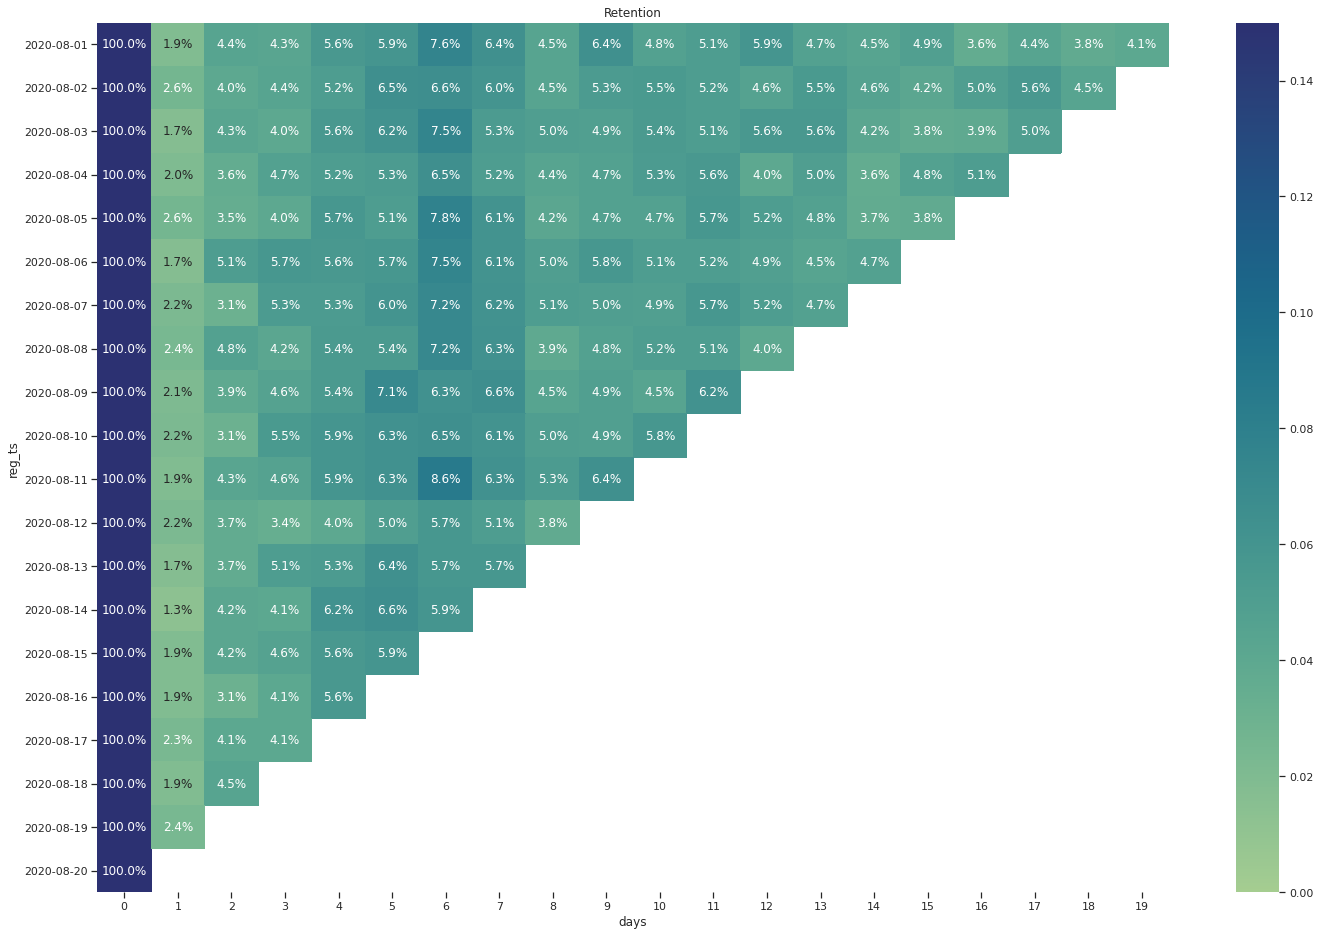

In [130]:
func_retention(reg_data, auth_data, start_date, end_date)

# Задание №2

Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.
Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

In [24]:
import pandas as pd
import requests
import urllib
import json
from urllib.parse import urlencode 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import plotly.express as px
from scipy import stats 
from scipy.stats import norm
from scipy.stats import chi2_contingency
from tqdm.auto import tqdm

plt.style.use('ggplot')

%matplotlib inline

In [25]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' # считываем данные 
public_key = 'https://disk.yandex.ru/d/SOkIsD5A8xlI7Q' 
final_url = base_url + urlencode(dict(public_key=public_key)) 
response = requests.get(final_url) 
download_url = response.json()['href'] 
download_response = requests.get(download_url) 
df = pd.read_csv(download_url, sep=';') 

In [26]:
# смотрим на типы данных, есть ли пропущенные значения, размер дф
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404770 entries, 0 to 404769
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    404770 non-null  int64 
 1   revenue    404770 non-null  int64 
 2   testgroup  404770 non-null  object
dtypes: int64(2), object(1)
memory usage: 9.3+ MB


In [27]:
# смотрим есть ли повторяющиеся значения
df.duplicated().sum()

0

In [28]:
# разделяем группы на a и b
control = df[df.testgroup == 'a']
test = df[df.testgroup == 'b']

In [29]:
# смотрим описание данных для контрольной группы
control.describe()

,user_id,revenue
count,202103.000000,202103.000000
mean,202555.909843,25.413720
std,116802.329266,920.768137
min,2.000000,0.000000
25%,101502.500000,0.000000
50%,202988.000000,0.000000
75%,303559.000000,0.000000
max,404769.000000,37433.000000


In [7]:
# смотрим описание данных для тестовой группы
test.describe()

,user_id,revenue
count,202667.000000,202667.000000
mean,202215.564389,26.751287
std,116891.926690,287.324162
min,1.000000,0.000000
25%,100855.500000,0.000000
50%,201821.000000,0.000000
75%,303602.500000,0.000000
max,404770.000000,4000.000000


Видим, что максимальные значения и стандартные отклонения у групп сильно отличаются.

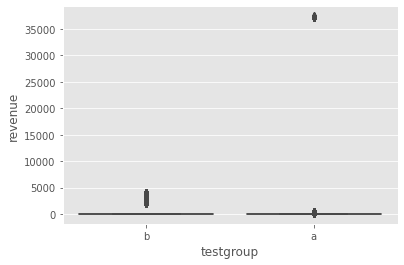

In [30]:
# посмотрим на распределение двух групп, в контрольной группе видны сильные выбросы
sns.boxplot(x='testgroup', y='revenue', data=df)

In [9]:
# посчитаем сколько таких "выбросов" 
control.query('revenue > 30000')['user_id'].count()

123

In [10]:
# посчитаем доход, который принесли "выбросы" из контрольной группы
control.query('revenue > 30000')['revenue'].sum()

4590252

In [11]:
# посчитаем доходы по каждой из групп
df.groupby('testgroup')['revenue'].sum()

testgroup
a    5136189
b    5421603
Name: revenue, dtype: int64

In [12]:
# видим, что "выбросы" в контрольной группе принесли ~89% от всей прибыли, поэтому считать их случайными неверно
4590252 / 5136189 

0.8937077665950377

Теперь сравним значения ARPU в двух группах на предмет наличия статистически значимых различий. 

In [32]:
# проверим данные на нормальность распределения
normal_control = stats.shapiro(control.revenue)
normal_test = stats.shapiro(test.revenue)
print(normal_control)
print(normal_test)

ShapiroResult(statistic=0.008876502513885498, pvalue=0.0)
ShapiroResult(statistic=0.06588172912597656, pvalue=0.0)


p_value = 0 для обеих групп, распределение отличается от нормального, поэтому использовать T-тест будет некорректно даже не смотря на размер выборки, для сравнения ARPU будем использовать бутстрап

In [33]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            len(data_column_1), 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            len(data_column_1), 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1)-statistic(samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

In [34]:
control_revenue = control.revenue
test_revenue = test.revenue

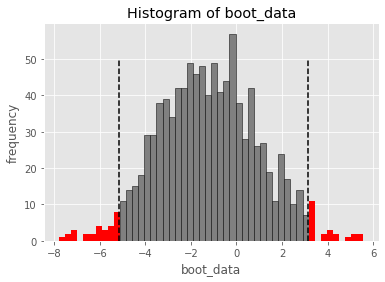

In [35]:
booted_data = get_bootstrap(control_revenue, test_revenue)

In [36]:
booted_data["p_value"]

0.575612185142292

p_value существенно > 0.05, что не позволяет нам отклонить нулевую гипотезу о равенстве средних, статистически значимые различия
ARPU в двух группах не выявлены.
Попробуем таким же образом сравнить метрику ARPPU

In [37]:
#формируем группы для сравнения ARPPU
control_paing = control[control.revenue > 0]
test_paing = test[test.revenue > 0]

In [38]:
#считаем ARPPU для a
control_paing.revenue.mean()

2663.9984439834025

In [39]:
#считаем ARPPU для b
test_paing.revenue.mean()

3003.6581717451522

In [40]:
#ARPPU в тестовой группе на ~ 12.8% больше, чем в контрольной
(3003.658 / 2663.998 - 1) * 100

12.750009572079257

In [43]:
# проверим данные на нормальность распределения
normal_control_paing = stats.shapiro(control_paing.revenue)
normal_test_paing = stats.shapiro(test_paing.revenue)
print(normal_control_paing)
print(normal_test_paing)

ShapiroResult(statistic=0.2667924761772156, pvalue=0.0)
ShapiroResult(statistic=0.9583123922348022, pvalue=2.491345674771425e-22)


p_value < 0.05 для обеих групп, распределение отличается от нормального, поэтому использовать T-тест будет некорректно даже не смотря на размер выборки, для сравнения ARPPU будем использовать бутстрап

In [44]:
control_paing_revenue = control_paing.revenue
test_paing_revenue = test_paing.revenue

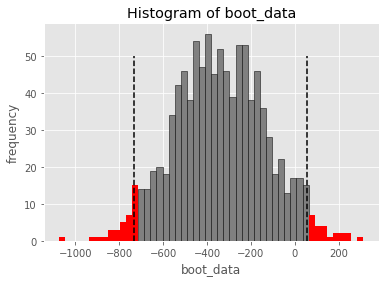

In [45]:
booted_data = get_bootstrap(control_paing_revenue, test_paing_revenue)

In [46]:
booted_data["p_value"]

0.10094497871889345

p_value уже ниже, чем при сравнении  ARPU, но полуенное значение все равно не позволяет нам отклонить нулевую гипотезу о равенстве ARPPU, статистически значимые различия ARPPU в двух группах не выявлены.

Теперь сравним конверсии в двух группах. Поскольку мы будем сравниваться категории пользователей: платящие / не платящие, в двух
группах, то будем использовать метод ХИ-квадрат для аналитики категориальных переменных. 

In [56]:
# считаем конверсию в двух группах 
conrol_conversion = 1928 / 202103 * 100
test_conversion = 1805 / 202667 * 100
print(conrol_conversion)
print(test_conversion)

0.9539690157988748
0.8906235351586593


In [57]:
# считаем разницу в конверсиях, конверсия в контрольной группе выше, чем в тестовой на 7%
(0.954 / 0.891 - 1) * 100

7.070707070707072

In [65]:
# присвоим каждому пользователю статус платящего / не платящего 
df['paing'] = df.revenue.apply(lambda x: True if x > 0 else False)
df.head()

,user_id,revenue,testgroup,paing
0,1,0,b,False
1,2,0,a,False
2,3,0,a,False
3,4,0,b,False
4,5,0,b,False


In [62]:
# считаем количество платящих и неплатящих пользователей для каждой группы
a_paing = df.query('testgroup == "a" and paing == True')['paing'].count()
a_no_paing = df.query('testgroup == "a" and paing == False')['paing'].count()
b_paing  = df.query('testgroup == "b" and paing == True')['paing'].count()
b_no_paing = df.query('testgroup == "b" and paing == False')['paing'].count()

In [63]:
# создаем массив с данными для проведения теста
T = np.array([[a_paing, a_no_paing], [b_paing, b_no_paing]])

In [66]:
# проводим тест
chi2_contingency(T)

(4.374729521260405,
 0.03647561892312613,
 1,
 array([[  1863.89924896, 200239.10075104],
        [  1869.10075104, 200797.89924896]]))

p_value < 0, метод ХИ-квадрат показал статистически значимые различия в конверсиях в группах.

# Выводы:
Для оценки качества наборов предложений в разных группах оценили следующие метрики: ARPU, ARPPU, конверсия.
Использованные методы для сравнения ARPU, ARPPU не показали статистически значимых различий, не смотря на то, что указанные метрики в тестовой группе выше. Напротив, сравнение конверссии методом ХИ-квадрат в двух группах показало статистически значимое различие в двух группа, в контрольной группе указанная метрика выше. Опираясь на результаты проведенных исследований, приходим к выводу, что набор предложений в контрольной группе является лучшим, по сравнению с тестовой группой. 

# Задание №3 

В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?

На мой взгляд, результаты последнего прошедшего события можно оценить  через анализ следующих метрик:
1. DAU на даты проведения последнего события, сравнить его с показателями в обычные дни и дни проведения других событий, а также после проведения события. Динамика количества пользователей в игре до и после события (WAU, MAU)
2. Retention rate, чтобы оценить сколько пользователей вернулось в приложение ради участия в событии, а также возвращаются ли они после проведения события.
3. Средняя продолжительность сессии (average session length), как она изменяется по сравнению с обычными днями и днями проведения других событий, а также как изменилась в дальнейшем. 
4. Stickness, позволит оценить стали ли пользователи чаще пользоваться приложением.
5. ARPU/ARPPU увеличился ли средний доход на одного пользователя/платящего пользователя во время проведения события или после него. 
6. Количество новых/отвалившихся пользователей, покажет помогает ли событие привлекать новых пользователей или негативно сказывается на процессе игры и пользователи уходят. 
7. Сколько пользователей проходят все уровни до конца, на каком этапе перестают играть или где сталкиваются с большим количеством сложностей. 


Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?

Вышеуказанные метрики остаются,  к анализу можно добавить:
1. Количество игроков откатившихся на несколько уровней назад и сколько из них в итоге остаются в игре и проходят все уровни.
2. Сколько игроков покидают игру после отката на несколько уровней.
